In [1]:
import numpy as np
from scipy.spatial import Delaunay
import cv2
import dlib
import random

import matplotlib.pyplot as plt
from matplotlib import path

%matplotlib inline

## 1 Correspondence

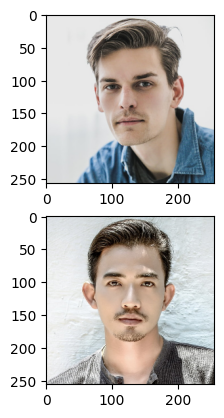

In [2]:
src_image = plt.imread('portrait0.jpeg')
dst_image = plt.imread('portrait1.jpeg')

src_image = cv2.resize(src_image, (256, 256))
dst_image = cv2.resize(dst_image, (256, 256))

fig, ax = plt.subplots(2, 1)
ax[0].imshow(src_image)
ax[1].imshow(dst_image)


In [3]:
def getShapePoints(img):

    height, width, c = img.shape

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    rects = detector(img, 0)
    shape = predictor(img, rects.pop())
    
    shape_array = [[0, 0], [0, width], [height, 0], [height, width]]
    for i in range(68):
        pt = shape.part(i)
        shape_array.append([pt.x, pt.y])
    shape_array = np.array(shape_array)

    return shape_array

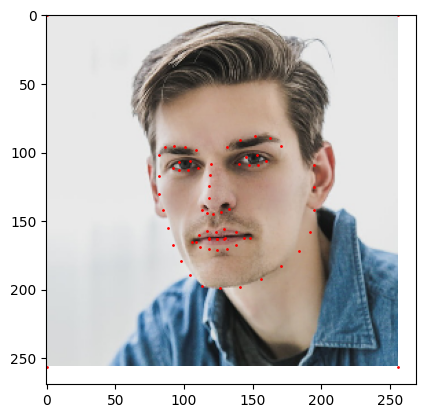

In [4]:
shape_src = getShapePoints(src_image)
plt.plot(shape_src[:, 0], shape_src[:, 1], 'ro', markersize=1)
plt.imshow(src_image)
plt.show()

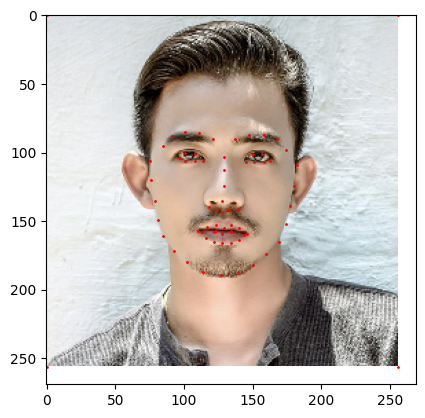

In [5]:
shape_dst = getShapePoints(dst_image)
plt.plot(shape_dst[:, 0], shape_dst[:, 1], 'ro', markersize=1)
plt.imshow(dst_image)
plt.show()

## 2 Mesh

In [6]:
def getDelaunayTriMesh(points):
    return Delaunay(points).simplices

(136, 3)


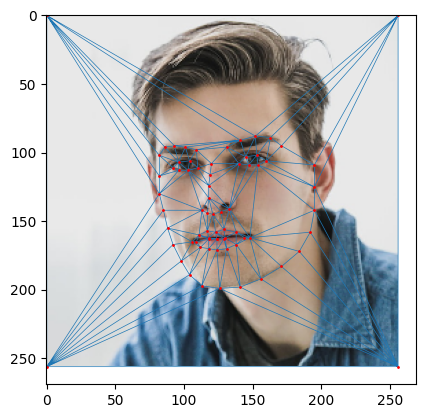

In [18]:
tri_src = getDelaunayTriMesh(shape_src)
print(tri_src.shape)
plt.triplot(shape_src[:, 0], shape_src[:, 1], tri_src, linewidth=0.5)
plt.plot(shape_src[:,0], shape_src[:,1], 'ro', markersize=1) 
plt.imshow(src_image)
plt.show()

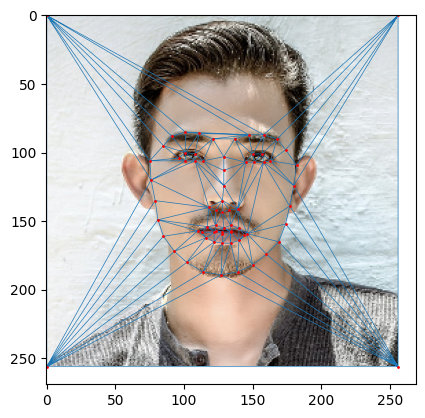

In [8]:
plt.triplot(shape_dst[:, 0], shape_dst[:, 1], tri_src, linewidth=0.5)
plt.plot(shape_dst[:,0], shape_dst[:,1], 'ro', markersize=1) 
plt.imshow(dst_image)
plt.show()

## 3 Blending with a mesh

In [9]:
def calAffineMat(tri_src, tri_dst):

    assert tri_src.shape == (3, 2) and tri_dst.shape == (3, 2)

    tri_src = np.hstack((tri_src, np.array([[1],[1],[1]]))).T
    tri_dst = np.hstack((tri_dst, np.array([[1],[1],[1]]))).T

    affineMat = tri_dst @ np.linalg.inv(tri_src)
    affineMat[2] = np.array([0., 0., 1.])

    return affineMat

In [11]:
def bilinearInterpolation(im, point):
    
    Q11 = np.floor(point).astype(np.uint32)
    Q12 = Q11 + np.array([0, 1])
    Q22 = Q11 + np.array([1, 1])
    Q21 = Q11 + np.array([1, 0])

    fQ = np.array([
        [im[Q11], im[Q12]],
        [im[Q21], im[Q22]]
    ])
    x = np.array([
        [Q21[0] - point[0], point[0] - Q11[0]],
    ])
    y = np.array([
        [Q21[1] - point[1], point[1] - Q11[1]],
    ]).T

    return x @ fQ @ y / (np.sum(x) * np.sum(y))

In [64]:
def inTriangle(points, triangle):
    
    # assert points.ndim == 2 and triangle.shape == (3, 2)
    return path.Path(triangle).contains_points(points, radius=1e-8)

In [52]:
x = np.linspace(0, 4, 5)
y = np.linspace(0, 4, 5)
print(x)
X, Y = np.meshgrid(x, y)
X = X[:, :, np.newaxis]
Y = Y[:, :, np.newaxis]
cor = np.concatenate((Y, X), axis=2).astype(np.int32)
print(cor.reshape((5*5, 2)))

[0. 1. 2. 3. 4.]
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]]


In [85]:
def calBetweenImage(im_src, points_src, im_dst, points_dst, w, tri_mesh):

    height, width = im_src.shape[:2]

    points_bet = (1 - w) * points_src + w * points_dst

    im_bet = np.zeros(im_src.shape)

    X, Y = np.meshgrid(np.linspace(0, height - 1, height), np.linspace(0, width - 1, width))
    X = X[:, :, np.newaxis]
    Y = Y[:, :, np.newaxis]
    cor = np.concatenate((Y, X), axis=2)
    cor_flat = cor.reshape((height * width, 2))
    tri_idx = np.zeros((height * width,))
    idx = 0
    for tri in tri_mesh:
        tri_is_in = inTriangle(cor_flat, points_bet[tri])
        tri_idx[tri_is_in] = idx
        idx += 1
    tri_idx = tri_idx.reshape((height, width)).astype(np.int32)



    return tri_idx
    


[35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

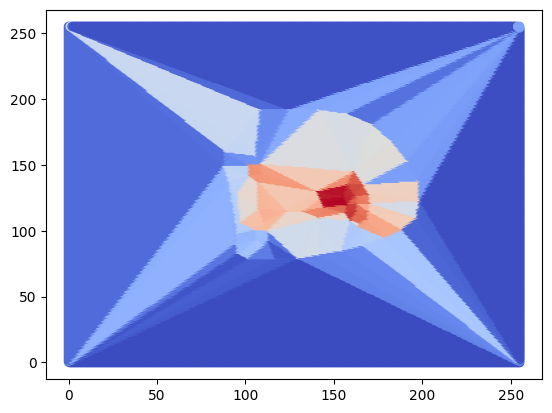

In [86]:
tri_idx = calBetweenImage(src_image, shape_src, dst_image, shape_dst, 0.0, tri_src)
for i in tri_idx:
    print(list(i))
X, Y = np.meshgrid(np.linspace(0, 255, 256), np.linspace(0, 255, 256))
plt.scatter(X, Y, marker='o', c=tri_idx, cmap='coolwarm')
plt.show()